In [1]:
import rasterio
import pandas as pd
import phenopy as phen
import rioxarray as xr # just to see the data
import numpy as np

Matplotlib is building the font cache; this may take a moment.


In [2]:
days = 'dates.txt'
inData = 'rasterTest2.tif'

dates = pd.read_csv(days, header=None)[0]
dates = pd.to_datetime(dates)
doy = dates.dt.dayofyear
#doy[:10]


0     85
1     96
2    106
3    136
4    145
5    166
6    175
7    196
8    205
9    215
Name: 0, dtype: int64

In [3]:
img = xr.open_rasterio(inData)
img

<xarray.DataArray (band: 116, y: 92, x: 97)>
[1035184 values with dtype=int16]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 110 111 112 113 114 115 116
  * y            (y) float64 4.222e+06 4.222e+06 ... 4.221e+06 4.221e+06
  * x            (x) float64 5.8e+05 5.8e+05 5.8e+05 ... 5.809e+05 5.809e+05
    spatial_ref  int64 0
Attributes:
    _FillValue:    -32767.0
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

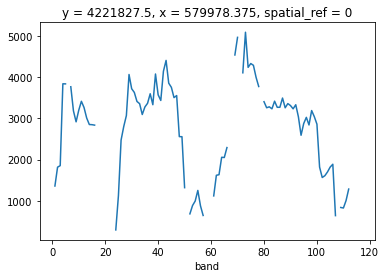

In [4]:
# mask nan
img = img.astype('Float32')
img.values[img.values == -32767.0] = np.nan
# plot one pixel of the time series
img.isel(x=0, y=0).plot()

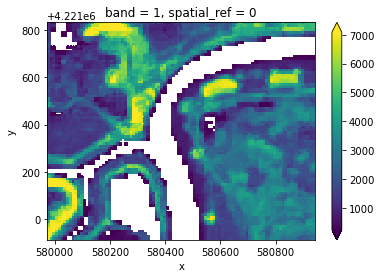

In [5]:
img.isel(band=0).plot(robust=True)

### making the phenoplot

 Parameters
 
* X: Float: X coordinates
* Y: Float: Y coordinates
* inData: String
        Absolute path to the original timeseries data
* dates: Series
        Dates of the original timeseries data [dtype: datetime64[ns]]
* type = String or Integer
        Interpolation type. Must be a string of ‘linear’, ‘nearest’,
        ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘RBF‘, ‘previous’,
        ‘next’, where ‘zero’, ‘slinear’, ‘quadratic’ and ‘cubic’ refer
        to a spline interpolation of zeroth, first, second or third order;
        ‘previous’ and ‘next’ simply return the previous or next value"
        of the point) or as an integer specifying the order of the"
        spline interpolator to use. RBF uses cubic interpolation.
        Default is ‘linear’.
* saveFigure: String
        Absolute path with extention to save figure on disk
* ylim: List of Integers or Float
        Limits of the Y axis [default the y min() and max() values]
* plotType: Type of plot, where 1 = plot with accumulated years; 2 = plot with
        start of the season (SOS), peak of the season (POS) and end of
        season (EOS);
        default is 1
* phenType: Type os estimation of SOS and EOS. 1 = median value between POS and start and end of season. 2 = using the knee inflexion method.
        default 1
* rollWindow: Integers
        Value of avarage smoothing of linear trend [default None]
* nGS: Integer
        Number of observations to predict the PhenoShape
        default is 46; one per week
* ylab: string
        Label of the Y axis [default "NDVI"]

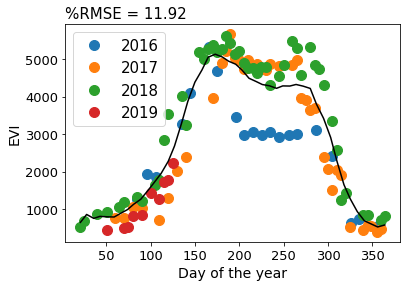

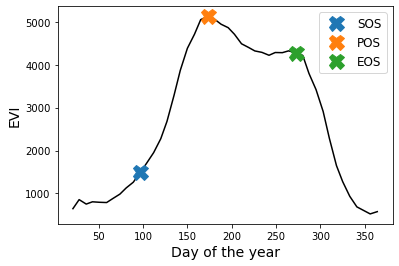

In [6]:
# Plot
X = 580404.65649
Y = 4221772.03998
phen.PhenoPlot(X=X, Y=Y, inData=inData, dates=dates, plotType=1,
               rollWindow=5, ylab='EVI')

phen.PhenoPlot(X=X, Y=Y, inData=inData, dates=dates, plotType=2, phentype=1,
               rollWindow=5, n_phen=10, ylab='EVI')


### Get phenological shape per pixel

Parameters

* inData: String
    Absolute path to the original timeseries data
- outData: String
    Absolute path with extention to save raster on disk
- interpolType: String or Integer
    Type of interpolation to perform. Options include ‘linear’, ‘nearest’,
    ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘RBF‘, ‘previous’, ‘next’,
    where ‘zero’, ‘slinear’, ‘quadratic’ and ‘cubic’ refer to a spline
    interpolation of zeroth, first, second or third order; ‘previous’ and
    ‘next’ simply return the previous or next value of the point.
     Integer numbers specify the order of the spline interpolator to use.
     Default is ‘linear’.
- doy: Day of the year vector data
    Dates of the original timeseries data [dtype: datetime64[ns]]
- nan_replace: Integer
    Value of the NaN data if there are any
- rollWindow: Integer
    Value of avarage smoothing of linear trend [default None]
- nGS: Integer
    Number of observations to predict the PhenoShape
    default is 46 [one per week]
- n_jobs: Integer
    Number of parallel jorb to apply during modeling
- chuckSize: Integer
    Size of raster chunks to be loaded during modeling
    Number must be multiple of 16 [GDAL specifications]
    default value is 256 [256 X 256 raster blocks]

you can se that the method has some problems with bimodal shapes

In [7]:
outData = 'rasterTest2_phen.tif'
# get phenological shape of the wetlands
phen.PhenoShape(inData=inData, outData=outData, doy=doy, rollWindow=5,
                nan_replace=-32767, nGS=46, chuckSize=16, n_jobs=8)


100%|██████████| 42/42 [00:15<00:00,  2.73it/s]


### Get land surface phenology metrics

At the moment thefollowing metrocs are available:

- SOS - DOY of Start of season
- POS - DOY of Peak of season
- POS - DOY of End of season
- vSOS - Vaues at start os season
- vPOS - Values at peak of season
- vEOS - Values at end of season
- LOS - Length of season
- MSP - Mid spring (DOY)
- MAU - Mid autum (DOY)
- vMSP - Value at mid spring
- vMAU - Value at mid autum
- AOS - Amplitude of season
- IOS - Integral of season [SOS-EOS]
- ROG - Rate of greening [slope SOS-POS]
- ROS - Rate of senescence [slope POS-EOS]
- SW - Skewness of growing season [SOS-EOS]

In [8]:
# get land surface phenology metrics
phen.PhenoLSP(inData=outData, outData=outData[:-4] + '_LSP2.tif', doy=doy, phentype=2,
              nGS=46, n_jobs=8, chuckSize=16)


100%|██████████| 42/42 [00:03<00:00, 13.59it/s]


### get interannual variations with %RMSE estimations

This is the basic function, which estimates the normalized root mean square error (%RMSE) for the entire phenological season. Areas with high error indicate high interannual variability

In [9]:
# get RMSE between the fitted phenoshape and the real distribution of values
phen.RMSE(inData, outData, outData[:-4] + '_RMSE.tif', dates)

100%|██████████| 8924/8924 [00:01<00:00, 7048.13it/s]


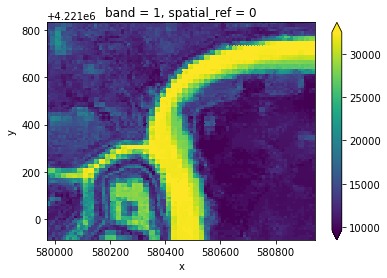

In [10]:
error = xr.open_rasterio(outData[:-4] + '_RMSE.tif')
error.plot(robust=True)